In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import silhouette_score
import seaborn as sns

In [ ]:
#import tables
transactions = pd.read_excel('/content/grocery_database.xlsx', sheet_name='transactions')
products = pd.read_excel('/content/grocery_database.xlsx', sheet_name='product_areas')

In [ ]:
transactions.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13


In [ ]:
products.head()

,product_area_id,product_area_name,profit_margin
0,1,Non-Food,0.25
1,2,Vegetables,0.18
2,3,Fruit,0.14
3,4,Dairy,0.19
4,5,Meat,0.11


In [ ]:
#merge on product_areas
transactions = pd.merge(transactions, products, on='product_area_id', how ='inner')

#drop Non Food categories
transactions = transactions.drop(transactions[transactions['product_area_name'] == 'Non-Food'].index)



In [ ]:
# aggregate sales at customer level for a product area
transactions.groupby(['customer_id','product_area_name'])['sales_cost'].sum().reset_index()

,customer_id,product_area_name,sales_cost
0,1,Dairy,367.74
1,1,Fruit,276.00
2,1,Meat,543.38
3,1,Vegetables,167.12
4,2,Dairy,150.63
...,...,...,...
3151,869,Vegetables,168.85
3152,870,Dairy,247.97
3153,870,Fruit,322.90
3154,870,Meat,284.26


In [ ]:
 transactions_summary_pivot = transactions.pivot_table(index='customer_id',
                              columns ='product_area_name',
                              values = 'sales_cost',
                              aggfunc='sum',
                              fill_value =0,
                              margins = True,
                              margins_name = 'Total').rename_axis(None, axis=1)
transactions_summary_pivot

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,367.74,276.00,543.38,167.12,1354.24
2,150.63,120.93,241.21,99.05,611.82
3,46.20,75.39,171.13,31.50,324.22
4,341.91,245.36,272.79,142.35,1002.41
5,694.71,815.32,1405.19,350.10,3265.32
...,...,...,...,...,...
867,129.84,176.73,180.49,88.83,575.89
868,225.59,358.89,343.26,189.24,1116.98
869,126.28,127.50,183.88,168.85,606.51


In [ ]:
# converting to percentage of total sales
transactions_summary_pivot = transactions_summary_pivot.div(transactions_summary_pivot['Total'],axis=0)

In [ ]:
transactions_summary_pivot

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,1.0
2,0.246200,0.197656,0.394250,0.161894,1.0
3,0.142496,0.232527,0.527821,0.097156,1.0
4,0.341088,0.244770,0.272134,0.142008,1.0
5,0.212754,0.249691,0.430338,0.107218,1.0
...,...,...,...,...,...
867,0.225460,0.306882,0.313411,0.154248,1.0
868,0.201964,0.321304,0.307311,0.169421,1.0
869,0.208208,0.210219,0.303177,0.278396,1.0


In [ ]:
# drop the total column
data_for_clustering = transactions_summary_pivot.drop(['Total'],axis=1)

In [ ]:
scale_norm = MinMaxScaler()
data_for_clustering_scaled = pd.DataFrame(scale_norm.fit_transform(data_for_clustering),columns=data_for_clustering.columns)

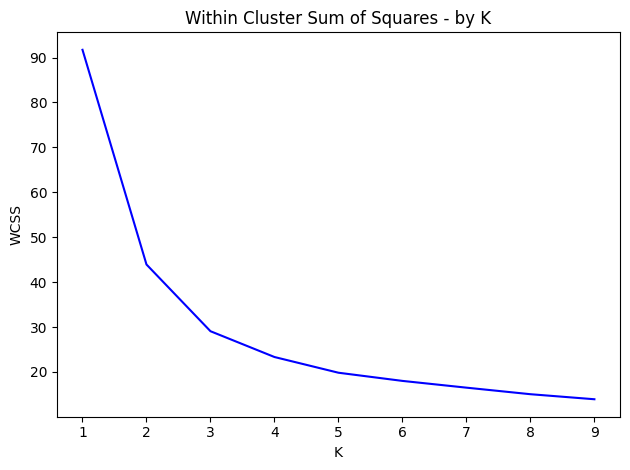

In [ ]:
# Use WCSS to find a good value for k

k_values = list(range(1,10))
wcss_list =[]

for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state = 42)
  kmeans.fit(data_for_clustering_scaled)
  wcss_list.append(kmeans.inertia_)

plt.plot(k_values,wcss_list,linestyle='-',color='b')
plt.xlabel('K')
plt.ylabel('WCSS')
plt.title('Within Cluster Sum of Squares - by K')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Silhouette Score - by K')

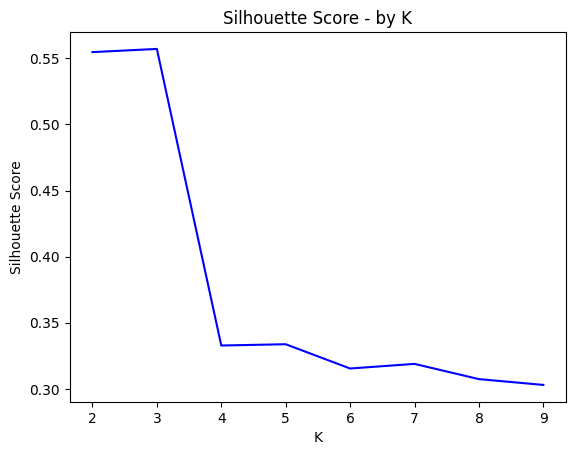

In [ ]:
## Silhouette Score

silhouette_score_list =[]
for cluster_size in range(2,10):

  kmeans = KMeans(n_clusters =cluster_size, random_state = 42)
  silhouette_score_list.append(silhouette_score(data_for_clustering_scaled, kmeans.fit_predict(data_for_clustering_scaled)))

plt.plot(range(2,10),silhouette_score_list,linestyle='-',color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score - by K')

In [ ]:
## Instantiate and Fit Model

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_for_clustering_scaled)

KMeans(n_clusters=3, random_state=42)

In [ ]:
## Use Cluster Information

# Add cluster labels to our data

data_for_clustering['cluster'] = kmeans.labels_

# checking cluster sizes

data_for_clustering['cluster'].value_counts(normalize=True) * 100

,proportion
cluster,
1,73.593571
0,14.580941
2,11.825488


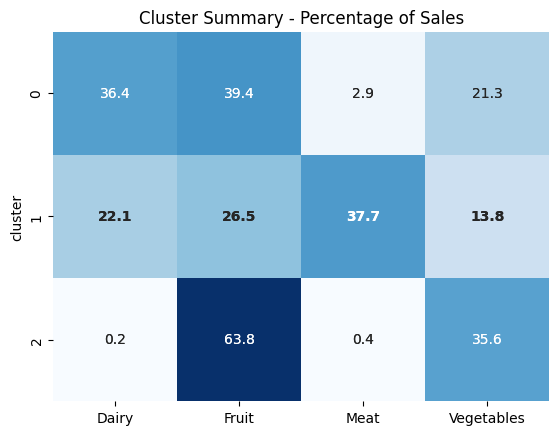

In [ ]:
## Profiles our clusters

cluster_summary = data_for_clustering.groupby('cluster')[['Dairy','Fruit','Meat','Vegetables']].agg('mean') * 100
cluster_summary.round(2)
sns.heatmap(cluster_summary, cmap='Blues', annot=True, cbar = False, fmt='.1f')
plt.title('Cluster Summary - Percentage of Sales')

ax = sns.heatmap(cluster_summary, cmap='Blues', annot=True, cbar=False, fmt='.1f')

for text in ax.texts:
    row, col = divmod(text.get_position()[1], 1)
    if row == 1:  # Bold the second row (index 1)
        text.set_fontweight('bold')

plt.show()